<a href="https://colab.research.google.com/github/cmansoo/scratch/blob/main/LSTM-alphabets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import numpy as np
import keras
import time

from keras.utils import to_categorical
from keras.layers import Dense, LSTM, Activation
from keras.models import Sequential

In [183]:
# measure training time
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

## 1. experiment 1

fixed length sequence with no padding
ABC -> D, BCD -> E, etc.

In [184]:
# define the raw data
alphabet='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
n_features = 1
seq_len = 3

# create a dictionary(map) of the letter index to character
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
dataX=[]; dataY=[]

for i in range(0, len(alphabet)-seq_len, 1):
  seq_in = alphabet[i:i + seq_len]
  seq_out = alphabet[i + seq_len]
  dataX.append([char_to_int[char] for char in seq_in])
  dataY.append(char_to_int[seq_out])
  print(seq_in, '->', seq_out)


X = np.array(dataX)
y = np.array(dataY)

# dataX.shape
# dataY.shape
X = X.reshape(len(dataX), seq_len, n_features)
# standardize?
X = X / float(len(alphabet))
# one hot encoding
y = to_categorical(y)

n_classes = y.shape[1]

ABC -> D
BCD -> E
CDE -> F
DEF -> G
EFG -> H
FGH -> I
GHI -> J
HIJ -> K
IJK -> L
JKL -> M
KLM -> N
LMN -> O
MNO -> P
NOP -> Q
OPQ -> R
PQR -> S
QRS -> T
RST -> U
STU -> V
TUV -> W
UVW -> X
VWX -> Y
WXY -> Z


In [185]:
# models
model = Sequential()
model.add(LSTM(32, input_shape=(seq_len, n_features), return_sequences=False))
model.add(Dense(n_classes, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 32)                4352      
                                                                 
 dense_22 (Dense)            (None, 26)                858       
                                                                 
Total params: 5210 (20.35 KB)
Trainable params: 5210 (20.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [186]:
# fit
time_callback = TimeHistory()
history = model.fit(X, y, epochs=400, batch_size=1, verbose=False, callbacks=[time_callback])
times = time_callback.times
# print(times)
print(sum(times))

26.73193645477295


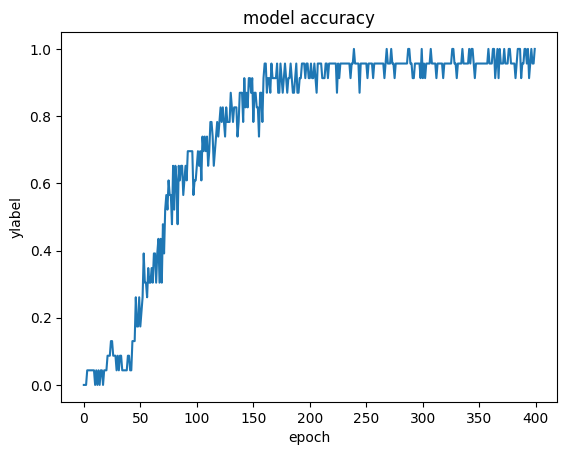

In [187]:
# plot
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("ylabel")
plt.show()

In [188]:
scores = model.evaluate(X, y)
y_pred = model.predict(X)

1/1 [==============================] - 0s 410ms/step


In [189]:
# show predictions
print("Model accuracy:", scores[1])

for ind, row in zip(y_pred.argmax(axis=1), dataX):
  pred_seq = [int_to_char[char] for char in row]
  pred_y = int_to_char[ind]
  print(pred_seq, "->", pred_y)

Model accuracy: 1.0
['A', 'B', 'C'] -> D
['B', 'C', 'D'] -> E
['C', 'D', 'E'] -> F
['D', 'E', 'F'] -> G
['E', 'F', 'G'] -> H
['F', 'G', 'H'] -> I
['G', 'H', 'I'] -> J
['H', 'I', 'J'] -> K
['I', 'J', 'K'] -> L
['J', 'K', 'L'] -> M
['K', 'L', 'M'] -> N
['L', 'M', 'N'] -> O
['M', 'N', 'O'] -> P
['N', 'O', 'P'] -> Q
['O', 'P', 'Q'] -> R
['P', 'Q', 'R'] -> S
['Q', 'R', 'S'] -> T
['R', 'S', 'T'] -> U
['S', 'T', 'U'] -> V
['T', 'U', 'V'] -> W
['U', 'V', 'W'] -> X
['V', 'W', 'X'] -> Y
['W', 'X', 'Y'] -> Z


## Experiment 2

variable length sequence with padding.
i.e. AB -> C, BCD -> E, CDEF -> G, etc. seq_len = 6 will be the max.

In [190]:
# preprocess data
dataX = []
dataY = []
max_len = 6 # seq_length
n_records = 100
n_features = 1
np.random.seed(100)

for i in range(n_records):
  start = np.random.randint(len(alphabet)-2)
  end = np.random.randint(start, min(start + max_len, len(alphabet) - 1))
  seq_in = alphabet[start:end + 1]
  seq_out = alphabet[end + 1]
  dataX.append([char_to_int[char] for char in seq_in])
  dataY.append(char_to_int[seq_out])
  print(seq_in, "->", seq_out)

# pad sequences
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(dataX, maxlen=max_len, dtype="float32")
# reshape
X = X.reshape(n_records, max_len, n_features)
# standardize X
X = X / float(len(alphabet))
# one hot encode Y
y = to_categorical(dataY)
n_classes = y.shape[1]

I -> J
D -> E
KLMNO -> P
CDEFGH -> I
CDE -> F
OPQ -> R
R -> S
PQRST -> U
LMNOP -> Q
QRST -> U
JKLMNO -> P
WXY -> Z
MNOPQ -> R
BCDEFG -> H
VWXY -> Z
EFGHI -> J
DE -> F
PQ -> R
OPQR -> S
QRS -> T
JKLM -> N
CDEFGH -> I
OP -> Q
QRSTUV -> W
GHIJK -> L
S -> T
CDEFGH -> I
KL -> M
IJKLMN -> O
KL -> M
V -> W
S -> T
TUVWXY -> Z
O -> P
NO -> P
MNO -> P
DEFG -> H
UVW -> X
X -> Y
PQRST -> U
DE -> F
QRSTU -> V
LMNOP -> Q
FGH -> I
KLMNO -> P
STUVWX -> Y
X -> Y
BCD -> E
GHI -> J
W -> X
X -> Y
TUVWXY -> Z
EFG -> H
EFGH -> I
XY -> Z
J -> K
QRSTUV -> W
WXY -> Z
FGH -> I
UVW -> X
HIJK -> L
TU -> V
CDEF -> G
XY -> Z
NOPQRS -> T
NOPQ -> R
QRSTU -> V
WXY -> Z
NOPQR -> S
DEFGH -> I
UVW -> X
IJ -> K
IJKLM -> N
VWX -> Y
X -> Y
MNOPQR -> S
AB -> C
IJKLM -> N
C -> D
FGHI -> J
CDEF -> G
OPQRST -> U
UV -> W
OPQR -> S
BCDEF -> G
I -> J
STU -> V
HIJ -> K
RST -> U
XY -> Z
NOP -> Q
ABC -> D
VWX -> Y
DEFGH -> I
FGH -> I
GH -> I
KLMNOP -> Q
RSTUVW -> X
CDEFG -> H
LMNOPQ -> R


In [191]:
# define model
model2 = Sequential()
model2.add(LSTM(32, input_shape=(max_len, n_features), return_sequences=False))
model2.add(Dense(n_classes, activation="softmax"))
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 32)                4352      
                                                                 
 dense_23 (Dense)            (None, 26)                858       
                                                                 
Total params: 5210 (20.35 KB)
Trainable params: 5210 (20.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [192]:
# fit
history = model2.fit(X, y, epochs=400, batch_size=1, verbose=False, callbacks=[time_callback])
times = time_callback.times
# print(times)
print(sum(times))

124.36076927185059


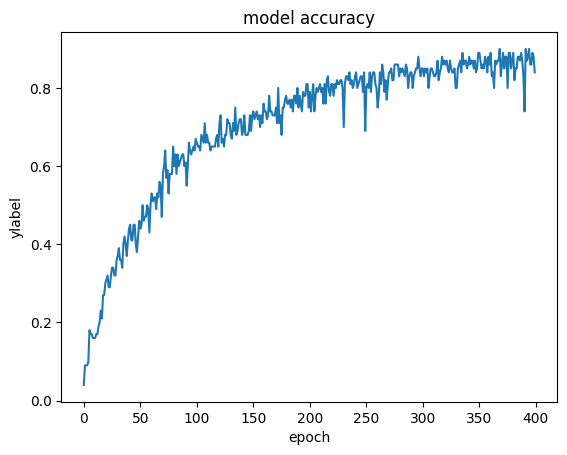

In [193]:
# plot
plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("ylabel")
plt.show()

In [194]:
scores = model2.evaluate(X, y)
y_pred = model2.predict(X)

4/4 [==============================] - 0s 4ms/step


In [195]:
# show predictions
print("Model accuracy:", scores[1])

for ind, row in zip(y_pred.argmax(axis=1), dataX):
  pred_seq = [int_to_char[char] for char in row]
  pred_y = int_to_char[ind]
  print(pred_seq, "->", pred_y)

Model accuracy: 0.8700000047683716
['I'] -> J
['D'] -> D
['K', 'L', 'M', 'N', 'O'] -> P
['C', 'D', 'E', 'F', 'G', 'H'] -> I
['C', 'D', 'E'] -> F
['O', 'P', 'Q'] -> R
['R'] -> T
['P', 'Q', 'R', 'S', 'T'] -> U
['L', 'M', 'N', 'O', 'P'] -> Q
['Q', 'R', 'S', 'T'] -> U
['J', 'K', 'L', 'M', 'N', 'O'] -> P
['W', 'X', 'Y'] -> Z
['M', 'N', 'O', 'P', 'Q'] -> R
['B', 'C', 'D', 'E', 'F', 'G'] -> H
['V', 'W', 'X', 'Y'] -> Z
['E', 'F', 'G', 'H', 'I'] -> J
['D', 'E'] -> F
['P', 'Q'] -> R
['O', 'P', 'Q', 'R'] -> S
['Q', 'R', 'S'] -> T
['J', 'K', 'L', 'M'] -> N
['C', 'D', 'E', 'F', 'G', 'H'] -> I
['O', 'P'] -> Q
['Q', 'R', 'S', 'T', 'U', 'V'] -> W
['G', 'H', 'I', 'J', 'K'] -> L
['S'] -> T
['C', 'D', 'E', 'F', 'G', 'H'] -> I
['K', 'L'] -> M
['I', 'J', 'K', 'L', 'M', 'N'] -> O
['K', 'L'] -> M
['V'] -> Y
['S'] -> T
['T', 'U', 'V', 'W', 'X', 'Y'] -> Z
['O'] -> P
['N', 'O'] -> P
['M', 'N', 'O'] -> P
['D', 'E', 'F', 'G'] -> H
['U', 'V', 'W'] -> Y
['X'] -> Y
['P', 'Q', 'R', 'S', 'T'] -> U
['D', 'E'] -> F
['Q'